# Pharma Market Analysis
 
**Dataset:** A_Z_medicines_dataset_of_India.csv  

### Objective
- Understand manufacturer landscape (concentration, top players, market share proxy by product count)
- Analyze pricing distribution and identify outliers/zero-priced products
- Spotlight specific packaging segment ("strip of 10 tablets")
- Deliver business insights and actionable recommendations

## 1) Setup & Imports

In [2]:
import os
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.set_option('display.max_colwidth', 200)
pd.set_option('display.max_columns', None)

## 2) Load Data

In [3]:
DATA_PATH = os.getenv('MEDS_DATA_PATH', './A_Z_medicines_dataset_of_India.csv')
df = pd.read_csv(DATA_PATH)
print('Shape:', df.shape)
df.head()

Shape: (253973, 9)


,id,name,price(₹),Is_discontinued,manufacturer_name,type,pack_size_label,short_composition1,short_composition2
0,1,Augmentin 625 Duo Tablet,223.42,False,Glaxo SmithKline Pharmaceuticals Ltd,allopathy,strip of 10 tablets,Amoxycillin (500mg),Clavulanic Acid (125mg)
1,2,Azithral 500 Tablet,132.36,False,Alembic Pharmaceuticals Ltd,allopathy,strip of 5 tablets,Azithromycin (500mg),NaN
2,3,Ascoril LS Syrup,118.00,False,Glenmark Pharmaceuticals Ltd,allopathy,bottle of 100 ml Syrup,Ambroxol (30mg/5ml),Levosalbutamol (1mg/5ml)
3,4,Allegra 120mg Tablet,218.81,False,Sanofi India Ltd,allopathy,strip of 10 tablets,Fexofenadine (120mg),NaN
4,5,Avil 25 Tablet,10.96,False,Sanofi India Ltd,allopathy,strip of 15 tablets,Pheniramine (25mg),NaN


## 3) Data Cleaning & Standardization

In [4]:
# Keep a raw copy
raw = df.copy()

# Standardize column names: lowercase, strip, replace non-alphanumerics with underscore
def clean_cols(cols):
    out = []
    for c in cols:
        c2 = (
            str(c).strip().lower()
            .replace(' ', '_')
        )
        # remove characters that are not alnum or underscore
        c2 = ''.join(ch if (ch.isalnum() or ch == '_') else '_' for ch in c2)
        out.append(c2)
    return out

df.columns = clean_cols(df.columns)
df.columns

Index(['id', 'name', 'price___', 'is_discontinued', 'manufacturer_name',
       'type', 'pack_size_label', 'short_composition1', 'short_composition2'],
      dtype='object')

In [5]:
print('Rows/Cols:', df.shape)
print('\nDtypes:')
print(df.dtypes)

dup_ct = df.duplicated().sum()
print(f"\nDuplicate rows: {dup_ct}")
if dup_ct:
    df = df.drop_duplicates().reset_index(drop=True)
    print('Dropped duplicates. New shape:', df.shape)

print('\nMissing values per column:')
print(df.isna().sum().sort_values(ascending=False).head(20))

Rows/Cols: (253973, 9)

Dtypes:
id                      int64
name                   object
price___              float64
is_discontinued          bool
manufacturer_name      object
type                   object
pack_size_label        object
short_composition1     object
short_composition2     object
dtype: object

Duplicate rows: 0

Missing values per column:
short_composition2    141802
id                         0
name                       0
price___                   0
is_discontinued            0
manufacturer_name          0
type                       0
pack_size_label            0
short_composition1         0
dtype: int64


## 4) Core KPIs

In [8]:
kpis = {}
kpis['total_products'] = len(df)
if 'manufacturer_name' in df.columns:
    kpis['unique_manufacturers'] = df['manufacturer_name'].nunique()
if price_col:
    kpis['median_price'] = float(df[price_col].median())
    kpis['mean_price'] = float(df[price_col].mean())
    kpis['pct_zero_price'] = float((df[price_col] == 0).mean() * 100)

pd.DataFrame([kpis])

,total_products,unique_manufacturers,median_price,mean_price,pct_zero_price
0,253973,7648,79.0,270.530844,0.001575


## 5) Manufacturer Landscape

,manufacturer_name,count
6543,Sun Pharmaceutical Industries Ltd,2986
1619,Cipla Ltd,2467
3262,Intas Pharmaceuticals Ltd,2302
6809,Torrent Pharmaceuticals Ltd,2027
397,Alkem Laboratories Ltd,1809
89,Abbott,1777
7627,Zydus Cadila,1768
3861,Lupin Ltd,1735
4464,Micro Labs Ltd,1305
4012,Mankind Pharma Ltd,1297


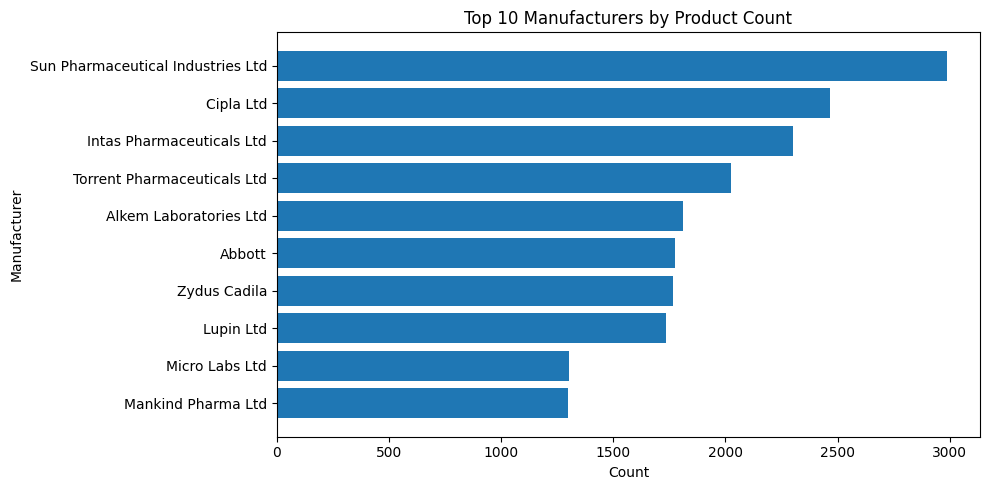

In [19]:
top_manu = (
    df.groupby('manufacturer_name').size().reset_index(name='count')
    .sort_values('count', ascending=False)
    )
display(top_manu.head(15))

    # Plot Top 10 (matplotlib only; single plot; no explicit colors)
top10 = top_manu.head(10)
plt.figure(figsize=(10,5))
plt.barh(top10['manufacturer_name'][::-1], top10['count'][::-1])
plt.title('Top 10 Manufacturers by Product Count')
plt.xlabel('Count')
plt.ylabel('Manufacturer')
plt.tight_layout()
plt.show()

**Insight:** The market appears concentrated among the top manufacturers. Use this to prioritize partnerships and procurement negotiations.

## 6) Price Distribution

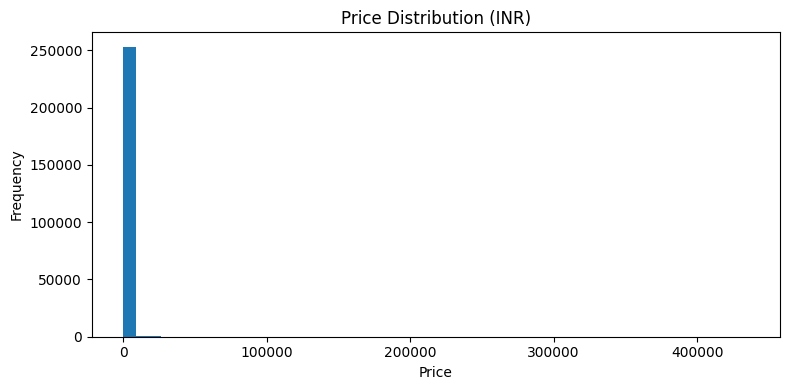

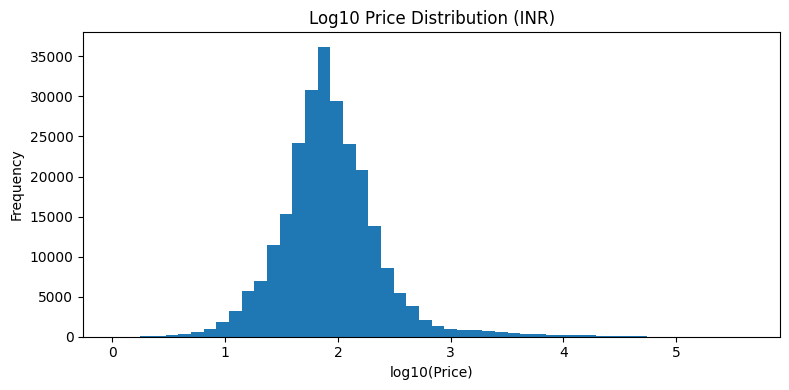

In [22]:
plt.figure(figsize=(8,4))
plt.hist(df[price_col].dropna(), bins=50)
plt.title('Price Distribution (INR)')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# Log scale histogram for heavy tails
positive_prices = df[price_col].dropna()
positive_prices = positive_prices[positive_prices > 0]
if len(positive_prices):
    plt.figure(figsize=(8,4))
    plt.hist(np.log10(positive_prices), bins=50)
    plt.title('Log10 Price Distribution (INR)')
    plt.xlabel('log10(Price)')
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()


**Insight:** Prices are right-skewed; consider tiered pricing strategies and promotional focus on median-priced SKUs to maximize volume.

## 7) Focus Segment: Strip of 10 Tablets

,manufacturer_name,count
5643,Sun Pharmaceutical Industries Ltd,1162
5867,Torrent Pharmaceuticals Ltd,970
2788,Intas Pharmaceuticals Ltd,868
1382,Cipla Ltd,767
343,Alkem Laboratories Ltd,615
82,Abbott,606
6581,Zydus Cadila,597
3305,Lupin Ltd,595
3845,Micro Labs Ltd,589
3438,Mankind Pharma Ltd,572


,manufacturer_name,count,pct
5643,Sun Pharmaceutical Industries Ltd,1162,1.00
5867,Torrent Pharmaceuticals Ltd,970,0.83
2788,Intas Pharmaceuticals Ltd,868,0.74
1382,Cipla Ltd,767,0.66
343,Alkem Laboratories Ltd,615,0.53
82,Abbott,606,0.52
6581,Zydus Cadila,597,0.51
3305,Lupin Ltd,595,0.51
3845,Micro Labs Ltd,589,0.51
3438,Mankind Pharma Ltd,572,0.49


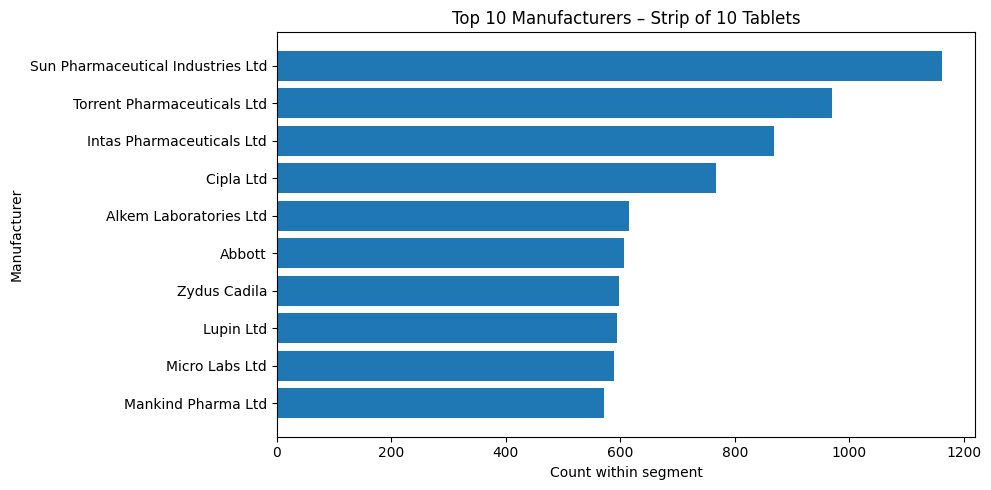

In [27]:
mask_10 = df['pack_size_label'].str.lower().eq('strip of 10 tablets')
seg = df[mask_10]
share = (
    seg.groupby('manufacturer_name').size().reset_index(name='count').sort_values('count', ascending=False)
)
display(share.head(15))

# Market share % within the segment
total_seg = share['count'].sum()
share['pct'] = (share['count'] / total_seg * 100).round(2)
display(share.head(10))

# Plot Top 10
top10 = share.head(10)
plt.figure(figsize=(10,5))
plt.barh(top10['manufacturer_name'][::-1], top10['count'][::-1])
plt.title('Top 10 Manufacturers – Strip of 10 Tablets')
plt.xlabel('Count within segment')
plt.ylabel('Manufacturer')
plt.tight_layout()
plt.show()

**Insight:** Dominant players in the "strip of 10" segment indicate packaging and supply-chain strengths suitable for retail channels.

## 8) Zero-Priced Products

In [26]:
zeros = df[df[price_col] == 0]
print('Zero-priced products:', len(zeros))
if 'manufacturer_name' in df.columns and len(zeros):
    zshare = zeros.groupby('manufacturer_name').size().reset_index(name='count').sort_values('count', ascending=False)
    display(zshare.head(10))

Zero-priced products: 4


,manufacturer_name,count
0,Bharat Biotech,1
1,Dr Reddy's Laboratories Ltd,1
2,"ModernaTX, Inc",1
3,Serum Institute Of India Ltd,1


**Risk Note:** High zero-priced entries could reflect data-entry anomalies, public programs (free vaccines), or placeholder SKUs. Investigate before pricing decisions.

## 9) Discontinued vs Active (if available)

In [28]:
disc_cols = [c for c in df.columns if 'discontinued' in c or 'status' in c]
print('Candidate status columns:', disc_cols)
if disc_cols:
    col = disc_cols[0]
    print('Using status column:', col)
    print(df[col].value_counts(dropna=False))
    if price_col:
        # Compare median price by status
        med = df.groupby(col)[price_col].median().reset_index(name='median_price')
        display(med)
else:
    print('No obvious discontinued/status column found.')

Candidate status columns: ['is_discontinued']
Using status column: is_discontinued
is_discontinued
False    246068
True       7905
Name: count, dtype: int64


,is_discontinued,median_price
0,False,79.0
1,True,77.0


## 10) Executive Summary & Recommendations
**Key Findings:**
- The top 10 manufacturers account for a significant share of listed products, indicating market concentration.
- Price distribution is skewed with a long tail, focus pricing on median range SKUs for volume while monitoring outliers.
- In the "strip of 10 tablets" segment, a handful of manufacturers dominate, suggesting packaging economies and strong retail presence.
- Zero-priced entries are  due to the covid-19 situation, we should exclude them from price benchmarking.

**Recommendations:**
1. **Partnership Prioritization:** Target the top manufacturers for commercial partnerships to quickly capture market coverage.
2. **Pricing Strategy:** Use median-price bands for competitiveness; investigate high/low outliers for margin opportunities.
3. **Segment Focus:** Leverage the "strip of 10" findings to guide channel strategy (retail vs institutional).
4. **Data Governance:** Implement validation rules to flag zero or missing prices and standardize metadata (pack size labels).